# Preparing Time Series from Wide-From Data
(Core)


  *Christina Brockway*

use data from Zillow House Value Index (ZHVI)
https://www.zillow.com/research/data/

-  Use home value data for:
  -  Data Type = 'ZHVI All Homes (SFR+Condo/Doop)-Time Series - Smoothed - Seasonally adjusted
  -  Geography = City

  -  https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv


### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns

import datetime as dt
import statsmodels.tsa.api as tsa

In [2]:
zhvi = pd.read_csv("data/City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
zhvi

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22462,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,NaN,NaN,...,198490.0,198467.0,196420.0,192002.0,191634.0,189383.0,191134.0,191343.0,192384.0,192110.0
22463,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,NaN,NaN,...,229251.0,232984.0,238245.0,240154.0,242470.0,243119.0,249098.0,255572.0,261910.0,264685.0
22464,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,53380.0,53662.0,...,132490.0,134951.0,137470.0,137430.0,137413.0,137615.0,138908.0,140096.0,141573.0,142438.0
22465,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,258191.0,261607.0,264571.0,266255.0


## Task Part 1

-  prepare the dataset for time series analysis:
  - load zillowHome Value Index dataframe
  - Filter the 4 largest cities into a dataframe
  - melt the data to long-form
    - convert melted dates to datetime
    - make datetime index column
  -  Resample the dataframe as monthly frequency, grouped by city

#### Filter 4 largets cities
("SizeRank" has ranked the cities by size ==> The larger the rank, the smaller the city)

In [3]:
zhvi4 = zhvi.loc[zhvi['SizeRank'] < 4]
zhvi4

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


#### Melt Data into Long Form

In [4]:
zhvi4.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'Metro', 'CountyName', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

In [5]:
zmelted = pd.melt(zhvi4.drop(columns=['RegionID', 'SizeRank', 'RegionType', 
                                      'StateName', 'State', 'Metro','CountyName']),
                                      id_vars=['RegionName'],
                             value_name='HomeValue', var_name='Date')
zmelted

,RegionName,Date,HomeValue
0,New York,2000-01-31,253690.0
1,Los Angeles,2000-01-31,234181.0
2,Houston,2000-01-31,109068.0
3,Chicago,2000-01-31,166139.0
4,New York,2000-02-29,255517.0
...,...,...,...
1087,Chicago,2022-08-31,315587.0
1088,New York,2022-09-30,781622.0
1089,Los Angeles,2022-09-30,966595.0
1090,Houston,2022-09-30,272639.0


### Resample dt monthly frequency, groupby city

In [6]:
#convert to datetime
zmelted['Date'] = pd.to_datetime(zmelted['Date'])
zmelted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionName  1092 non-null   object        
 1   Date        1092 non-null   datetime64[ns]
 2   HomeValue   1087 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.7+ KB


In [7]:
# Set index to datetime
zmelted = zmelted.set_index('Date')
zmelted.head()

,RegionName,HomeValue
Date,,
2000-01-31,New York,253690.0
2000-01-31,Los Angeles,234181.0
2000-01-31,Houston,109068.0
2000-01-31,Chicago,166139.0
2000-02-29,New York,255517.0


In [8]:
#Resample dt monthly frequency groupby city
#Set mothly frequency
ts = zmelted.groupby('RegionName').resample('MS').sum(numeric_only=False)
ts

RegionName  HomeValue
RegionName Date                            
Chicago    2000-01-01    Chicago   166139.0
           2000-02-01    Chicago   166536.0
           2000-03-01    Chicago   167368.0
           2000-04-01    Chicago   168826.0
           2000-05-01    Chicago   170499.0
...                          ...        ...
New York   2022-05-01   New York   768797.0
           2022-06-01   New York   773944.0
           2022-07-01   New York   777692.0
           2022-08-01   New York   779960.0
           2022-09-01   New York   781622.0

[1092 rows x 2 columns]

In [9]:
ts.head()

RegionName  HomeValue
RegionName Date                            
Chicago    2000-01-01    Chicago   166139.0
           2000-02-01    Chicago   166536.0
           2000-03-01    Chicago   167368.0
           2000-04-01    Chicago   168826.0
           2000-05-01    Chicago   170499.0

In [10]:
df= ts[ts.isna()]
df

RegionName  HomeValue
RegionName Date                            
Chicago    2000-01-01        NaN        NaN
           2000-02-01        NaN        NaN
           2000-03-01        NaN        NaN
           2000-04-01        NaN        NaN
           2000-05-01        NaN        NaN
...                          ...        ...
New York   2022-05-01        NaN        NaN
           2022-06-01        NaN        NaN
           2022-07-01        NaN        NaN
           2022-08-01        NaN        NaN
           2022-09-01        NaN        NaN

[1092 rows x 2 columns]

In [11]:
#Impute NaN
tsi = ts.fillna(method='ffill')
tsi.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1092 entries, ('Chicago', Timestamp('2000-01-01 00:00:00', freq='MS')) to ('New York', Timestamp('2022-09-01 00:00:00', freq='MS'))
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  1092 non-null   object 
 1   HomeValue   1092 non-null   float64
dtypes: float64(1), object(1)
memory usage: 30.8+ KB


In [12]:
tsi.min()

RegionName    Chicago
HomeValue         0.0
dtype: object

In [13]:
tsi = tsi[tsi.HomeValue !=0]
tsi.min()

RegionName     Chicago
HomeValue     108834.0
dtype: object

## Task Part 2

-  Plot the home values for all 4 cities
    - Add title and axis labels
    - Reformat the y-axis ticks to use thousands of dollars with a "K" at the end

In [14]:
# Unstack dataframe to visualize
tsunstacked = tsi.unstack(level=0)
tsunstacked

RegionName                                 HomeValue            \
RegionName    Chicago  Houston  Los Angeles  New York   Chicago   Houston   
Date                                                                        
2000-01-01    Chicago  Houston  Los Angeles  New York  166139.0  109068.0   
2000-02-01    Chicago  Houston  Los Angeles  New York  166536.0  109079.0   
2000-03-01    Chicago  Houston  Los Angeles  New York  167368.0  108878.0   
2000-04-01    Chicago  Houston  Los Angeles  New York  168826.0  108881.0   
2000-05-01    Chicago  Houston  Los Angeles  New York  170499.0  108834.0   
...               ...      ...          ...       ...       ...       ...   
2022-05-01    Chicago  Houston  Los Angeles  New York  312487.0  265558.0   
2022-06-01    Chicago  Houston  Los Angeles  New York  314663.0  268901.0   
2022-07-01    Chicago  Houston  Los Angeles  New York  315910.0  271059.0   
2022-08-01    Chicago  Houston  Los Angeles  New York  315587.0  272400.0   
2022-09-01    Chicago  Houston  Los Angeles  New York  315429.0  272639.0   

                                  
RegionName Los Angeles  New York  
Date                              
2000-01-01    234181.0  253690.0  
2000-02-01    234401.0  255517.0  
2000-03-01    235513.0  257207.0  
2000-04-01    237589.0  260310.0  
2000-05-01    240113.0  263204.0  
...                ...       ...  
2022-05-01    990391.0  768797.0  
2022-06-01    992337.0  773944.0  
2022-07-01    992630.0  777692.0  
2022-08-01    978196.0  779960.0  
2022-09-01    966595.0  781622.0  

[273 rows x 8 columns]

In [15]:
#Change thousand to K
def thousands(x,pos):
    """function for use with mpl FuncFormatter"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
#Create the formatter
fmt_thous = mticks.FuncFormatter(thousands)

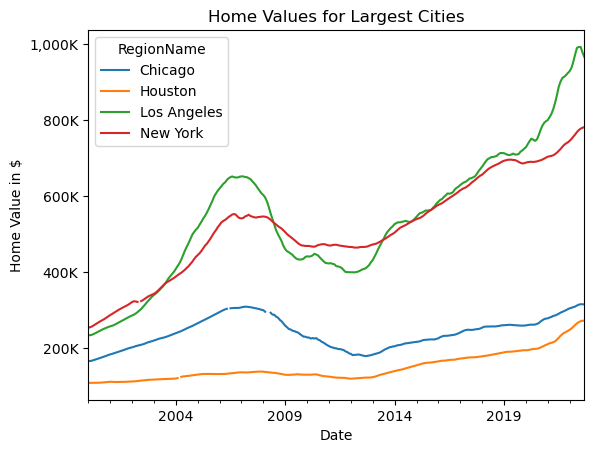

In [16]:
ax = tsunstacked['HomeValue'].plot()
fmt_thous = mticks.FuncFormatter(thousands)
ax.yaxis.set_major_formatter(fmt_thous)
ax.set_ylabel('Home Value in $')
ax.set(title = 'Home Values for Largest Cities');

# Q1: 
    -  Which city had the highest typical Home Value at the end of 2008? *New York*
    -  Which city had the least? *Houston*

In [17]:
tsi.loc[pd.IndexSlice[:, 'December 2008'],:]

,,RegionName,HomeValue
RegionName,Date,,
Chicago,2008-12-01,Chicago,265306.0
Houston,2008-12-01,Houston,131283.0
Los Angeles,2008-12-01,Los Angeles,469294.0
New York,2008-12-01,New York,510309.0


# Q2:

**How much did the Home Values Change from November 2008 to December 2008?**

****
All of the home prices dropped from November 2008 to December 2800*8


Chicago: $5,753.00

Houston: $964.00

Los Angeles: $12,611.00

New York: $4,458.00

In [18]:
df2= tsunstacked.loc['2008','HomeValue']
df2

RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2008-01-01,300207.0,138208.0,603029.0,546538.0
2008-02-01,296063.0,137512.0,596635.0,546098.0
2008-03-01,NaN,136795.0,586065.0,544562.0
2008-04-01,NaN,136628.0,571226.0,541865.0
2008-05-01,293467.0,136228.0,554589.0,537685.0
2008-06-01,288495.0,135773.0,539622.0,533810.0
2008-07-01,288174.0,135392.0,524220.0,529211.0
2008-08-01,283199.0,134770.0,510520.0,525290.0
2008-09-01,280695.0,133932.0,500124.0,521347.0


In [19]:
compare = df2.loc['November 2008':'December 2008']
compare

RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2008-11-01,271059.0,132247.0,481905.0,514767.0
2008-12-01,265306.0,131283.0,469294.0,510309.0


In [20]:
compare_diff = compare.diff().dropna()
compare_diff

RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2008-12-01,-5753.0,-964.0,-12611.0,-4458.0
